<h1>First try with ADAM</h1>

In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import numpy as np
import tensorflow as tf # changed to intel-optimized build

tf.random.set_seed(42)
np.random.seed(42)

import gc
import time
import random
from winsound import Beep
from PIL import Image
import pickle
Beep(1000, 100)
def beep():
    Beep(1000, 100)

In [3]:
from matplotlib import pyplot as plt

In [5]:
os.chdir(r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env")

<h1>load super-expanded training data</h1>

In [6]:
os.chdir(r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env")
with open('useful_e_data.pkl', 'rb') as f:
    [train_x, val_x, test_x, train_y, val_y, test_y] = pickle.load(f)
    
Beep(1000, 100)

# reshape data
train_x = train_x.reshape(np.shape(train_x)[0], np.shape(train_x)[1], np.shape(train_x)[2], 1)
val_x = val_x.reshape(np.shape(val_x)[0], np.shape(val_x)[1], np.shape(val_x)[2], 1)
test_x = test_x.reshape(np.shape(test_x)[0], np.shape(test_x)[1], np.shape(test_x)[2], 1)

train_y = tf.one_hot(train_y.astype(np.int32), depth=10)
val_y = tf.one_hot(val_y.astype(np.int32), depth=10)
test_y = tf.one_hot(test_y.astype(np.int32), depth=10)
Beep(1000, 100)


<h1>sample training data<h1/>

In [9]:
# # sample training data
# n = len(train_x)
# sn = int(n / 10)
# np.random.seed(42)
# index = np.random.choice([i for i in range(n)], size=sn, replace=False)

# sub_tx, sub_ty = [], []

# for ind in index:
#     sub_tx.append(train_x[ind])
#     sub_ty.append(train_y[ind])

# sub_tx = np.array(sub_tx)
# sub_ty = np.array(sub_ty)
# sub_tx = sub_tx.reshape(np.shape(sub_tx)[0], np.shape(sub_tx)[1], np.shape(sub_tx)[2], 1)

# Beep(1000, 100)

<h1>Useful functions:<h1/>

In [9]:
# def plot_decay(init_val, rate, nep):
#     dec_list = []
#     val = init_val
#     rate = rate
#     for i in range(nep):
#         dec_list.append(val)
#         val = rate * val

#     plt.plot(dec_list)
#     plt.axhline(min(dec_list))
#     plt.show()
#     print('init eta:', init_val)
#     print('min eta:', min(dec_list))
#     print('#' * 50)

# Beep(1000, 100)

<h1>Build Network models</h1>

<h2>ADAM:<h2/>

In [22]:

def train_cnn_adam( # using default ADAM params
        lmbda,
        batch_size,
        n_eph,
        train_x,
        train_y,
        val_x,
        val_y,
        test_x,
        test_y,
        addr
    ):
    ################################################################
    #   relu CNN network as described in chapter 6
    ################################################################
    tf.random.set_seed(42)
    ################################################################
    print('lmbda= {}\n'.format(lmbda))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    ################################################################
    ################################################################
    # construct netwoek model
    input_shape = (28, 28, 1)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D( # no padding
            20,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda),
            input_shape=input_shape))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Conv2D( # no padding
            40,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
            1000,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))
    ################################################################

    ################################################################
    # optimizer: SGD
#     optimizer_sgd = tf.keras.optimizers.SGD(
#         learning_rate=lr_schedule,
#         momentum=0.0,
#         nesterov=False,
#         name="SGD"
#     )
#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=eta,
#         decay_steps=decay_steps,
#         decay_rate=decay_rate
#     )
    ################################################################
    # optimizer: ADAM
    optimizer_adam = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam'
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=optimizer_adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    # save the model when val_acc is best
    stamp = str(time.time()).replace('.', '_')
    print('\n\n\ntime stamp:', stamp + '\n\n\n')
    checkpoint_filepath = addr + '\{}'.format(stamp)
    print('checkpoint_filepath:',checkpoint_filepath)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    ################################################################
    ################################################################
    #    train model  
    ts = time.time()
    history = model.fit(
        train_x, train_y, 
        epochs=n_eph,
        batch_size=batch_size,
        validation_data=(val_x, val_y),
        callbacks=[model_checkpoint_callback],
        shuffle=True
    )
    te = time.time()

    print('total time:', te - ts)
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    ################################################################
    ################################################################
    #    load the weights for the best epoch (best val accuracy)
    model.load_weights(checkpoint_filepath)
    ################################################################
    ################################################################
    #    evaluate test data at the best epoch
    [test_data_loss, test_data_accuracy] = model.evaluate(
        test_x, test_y,
        batch_size=len(test_x)
    )
    ################################################################
    plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
    plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
    plt.title('CNN relu, expanded train data, ADAM, lmbda={}, {} epochs'.format(lmbda, n_eph))
    plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
    plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
    plt.legend()
    plt.show()
    Beep(1000, 100)
    print('acc', acc)
    print('loss', loss)
    print('val_acc', val_acc)
    print('val_loss', val_loss)

Beep(1000,100)


<h1>Fully train ADAM network<h1/>

lmbda= 0.0001

n_eph= 88

batch_size= 10

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 40)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              641000    
_________________________________________________________________
dense_17 (D

75000/75000 [==============================] - 565s 8ms/step - loss: 0.0419 - accuracy: 0.9933 - val_loss: 0.0617 - val_accuracy: 0.9902
Epoch 46/88
75000/75000 [==============================] - 561s 7ms/step - loss: 0.0424 - accuracy: 0.9933 - val_loss: 0.0562 - val_accuracy: 0.9916
Epoch 47/88
75000/75000 [==============================] - 561s 7ms/step - loss: 0.0417 - accuracy: 0.9934 - val_loss: 0.0584 - val_accuracy: 0.9914
Epoch 48/88
75000/75000 [==============================] - 561s 7ms/step - loss: 0.0417 - accuracy: 0.9934 - val_loss: 0.0627 - val_accuracy: 0.9894
Epoch 49/88
75000/75000 [==============================] - 561s 7ms/step - loss: 0.0417 - accuracy: 0.9934 - val_loss: 0.0663 - val_accuracy: 0.9906
Epoch 50/88
75000/75000 [==============================] - 561s 7ms/step - loss: 0.0415 - accuracy: 0.9935 - val_loss: 0.0679 - val_accuracy: 0.9898
Epoch 51/88
75000/75000 [==============================] - 561s 7ms/step - loss: 0.0416 - accuracy: 0.9934 - val_loss:

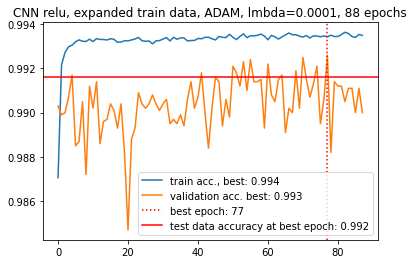

acc [0.987064003944397, 0.9921640157699585, 0.9927226901054382, 0.9929773211479187, 0.9930493235588074, 0.9932013154029846, 0.9932893514633179, 0.9932253360748291, 0.9932186603546143, 0.9933199882507324, 0.9932146668434143, 0.9933466911315918, 0.9933093190193176, 0.9933080077171326, 0.9932839870452881, 0.9933426380157471, 0.9933133125305176, 0.993179976940155, 0.9931906461715698, 0.9932506680488586, 0.9932439923286438, 0.993287980556488, 0.9933293461799622, 0.993399977684021, 0.9932493567466736, 0.9932266473770142, 0.9932399988174438, 0.9931093454360962, 0.9932439923286438, 0.9932559728622437, 0.9933266639709473, 0.993394672870636, 0.9932399988174438, 0.9934053421020508, 0.9933173060417175, 0.9933786392211914, 0.9933773279190063, 0.9932399988174438, 0.9932613372802734, 0.9932653307914734, 0.9933506846427917, 0.9933386445045471, 0.993403971195221, 0.9934106469154358, 0.9933386445045471, 0.993287980556488, 0.9934466481208801, 0.993403971195221, 0.993394672870636, 0.9935426712036133, 0.99

13828

In [23]:
lmbda = 0.1 / 10 / 10 / 10
batch_size = 10
n_eph = 88

addr = r'C:\Users\mchen\OneDrive\桌面\ml\MNIST\models'

a = train_cnn_adam( # using default ADAM params
    lmbda,
    batch_size,
    n_eph,
    train_x,
    train_y,
    val_x,
    val_y,
    test_x,
    test_y,
    addr
)

del a
gc.collect()



In [27]:

def train_cnn_adam_2( # using default ADAM params
        lmbda,
        batch_size,
        n_eph,
        train_x,
        train_y,
        val_x,
        val_y,
        test_x,
        test_y,
        addr
    ):
    ################################################################
    #   relu CNN network as described in chapter 6
    ################################################################
    tf.random.set_seed(42)
    ################################################################
    print('lmbda= {}\n'.format(lmbda))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    ################################################################
    ################################################################
    # construct netwoek model
    input_shape = (28, 28, 1)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D( # no padding
            40,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda),
            input_shape=input_shape))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Conv2D( # no padding
            40,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
            1000,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.Dense(
            100,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))
    
    model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))
    ################################################################

    
    
    
    
    ################################################################
    # optimizer: ADAM
    optimizer_adam = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam'
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=optimizer_adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    # save the model when val_acc is best
    stamp = str(time.time()).replace('.', '_')
    print('\n\n\ntime stamp:', stamp + '\n\n\n')
    checkpoint_filepath = addr + '\{}'.format(stamp)
    print('checkpoint_filepath:',checkpoint_filepath)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    ################################################################
    ################################################################
    #    train model  
    ts = time.time()
    history = model.fit(
        train_x, train_y, 
        epochs=n_eph,
        batch_size=batch_size,
        validation_data=(val_x, val_y),
        callbacks=[model_checkpoint_callback],
        shuffle=True
    )
    te = time.time()

    print('total time:', te - ts)
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    ################################################################
    ################################################################
    #    load the weights for the best epoch (best val accuracy)
    model.load_weights(checkpoint_filepath)
    ################################################################
    ################################################################
    #    evaluate test data at the best epoch
    [test_data_loss, test_data_accuracy] = model.evaluate(
        test_x, test_y,
        batch_size=len(test_x)
    )
    beep()
    print('acc', acc)
    print('loss', loss)
    print('val_acc', val_acc)
    print('val_loss', val_loss)
    ################################################################
    plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
    plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
    plt.title('CNN relu, expanded train data, ADAM, lmbda={}, {} epochs'.format(lmbda, n_eph))
    plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
    plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
    plt.legend()
    plt.show()
    print('acc', acc)
    print('loss', loss)
    print('val_acc', val_acc)
    print('val_loss', val_loss)

beep()

lmbda= 0.0001

n_eph= 128

batch_size= 10

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 24, 24, 40)        1040      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 40)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 40)          40040     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 4, 4, 40)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              641000    
_________________________________________________________________
dense_19 (

75000/75000 [==============================] - 676s 9ms/step - loss: 0.0444 - accuracy: 0.9932 - val_loss: 0.0521 - val_accuracy: 0.9926
Epoch 45/128
75000/75000 [==============================] - 678s 9ms/step - loss: 0.0443 - accuracy: 0.9933 - val_loss: 0.0593 - val_accuracy: 0.9912
Epoch 46/128
75000/75000 [==============================] - 677s 9ms/step - loss: 0.0443 - accuracy: 0.9933 - val_loss: 0.0624 - val_accuracy: 0.9891
Epoch 47/128
75000/75000 [==============================] - 679s 9ms/step - loss: 0.0444 - accuracy: 0.9933 - val_loss: 0.0565 - val_accuracy: 0.9915
Epoch 48/128
75000/75000 [==============================] - 679s 9ms/step - loss: 0.0445 - accuracy: 0.9932 - val_loss: 0.0618 - val_accuracy: 0.9901
Epoch 49/128
75000/75000 [==============================] - 678s 9ms/step - loss: 0.0445 - accuracy: 0.9932 - val_loss: 0.0569 - val_accuracy: 0.9907
Epoch 50/128
75000/75000 [==============================] - 679s 9ms/step - loss: 0.0439 - accuracy: 0.9932 - val

75000/75000 [==============================] - 678s 9ms/step - loss: 0.0429 - accuracy: 0.9932 - val_loss: 0.0561 - val_accuracy: 0.9910
Epoch 98/128
75000/75000 [==============================] - 678s 9ms/step - loss: 0.0428 - accuracy: 0.9933 - val_loss: 0.0565 - val_accuracy: 0.9905
Epoch 99/128
75000/75000 [==============================] - 676s 9ms/step - loss: 0.0433 - accuracy: 0.9932 - val_loss: 0.0574 - val_accuracy: 0.9919
Epoch 100/128
75000/75000 [==============================] - 675s 9ms/step - loss: 0.0432 - accuracy: 0.9932 - val_loss: 0.0541 - val_accuracy: 0.9916
Epoch 101/128
75000/75000 [==============================] - 680s 9ms/step - loss: 0.0431 - accuracy: 0.9932 - val_loss: 0.0626 - val_accuracy: 0.9908
Epoch 102/128
75000/75000 [==============================] - 677s 9ms/step - loss: 0.0433 - accuracy: 0.9932 - val_loss: 0.0548 - val_accuracy: 0.9904
Epoch 103/128
75000/75000 [==============================] - 678s 9ms/step - loss: 0.0429 - accuracy: 0.9932 -

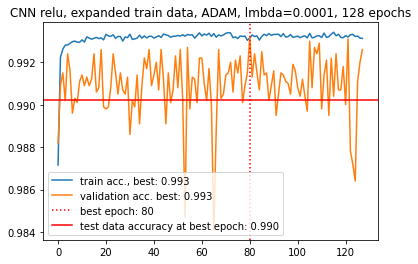

acc [0.9871613383293152, 0.9922306537628174, 0.9926226735115051, 0.9928053617477417, 0.9928173422813416, 0.9928920269012451, 0.9929720163345337, 0.9929999709129333, 0.9929479956626892, 0.9929440021514893, 0.9930573105812073, 0.9929519891738892, 0.9932000041007996, 0.9931399822235107, 0.9930906891822815, 0.9931333065032959, 0.9931706786155701, 0.9931186437606812, 0.9931493401527405, 0.9930573105812073, 0.9933199882507324, 0.9932413101196289, 0.9932199716567993, 0.9932960271835327, 0.9931333065032959, 0.9932199716567993, 0.9932119846343994, 0.9930013418197632, 0.9931933283805847, 0.9931613206863403, 0.9933239817619324, 0.9930786490440369, 0.9930999875068665, 0.9931386709213257, 0.9932786822319031, 0.9931373596191406, 0.9932399988174438, 0.9931480288505554, 0.9932253360748291, 0.9932253360748291, 0.9931413531303406, 0.9931933283805847, 0.9932519793510437, 0.993173360824585, 0.9933306574821472, 0.9932906627655029, 0.9932626485824585, 0.99317866563797, 0.993228018283844, 0.993229329586029, 

23122

In [28]:
lmbda = 0.1 / 10 / 10 / 10
batch_size = 10
n_eph = 128

addr = r'C:\Users\mchen\OneDrive\桌面\ml\MNIST\models'

a = train_cnn_adam_2( # using default ADAM params
    lmbda,
    batch_size,
    n_eph,
    train_x,
    train_y,
    val_x,
    val_y,
    test_x,
    test_y,
    addr
)

del a
gc.collect()

